### Install packages you will need

In [1]:
!pip install --user --upgrade matplotlib mplhep pandas

  Using cached matplotlib-3.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached mplhep-0.3.55-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached mplhep_data-0.0.4-py3-none-any.whl.metadata (3.4 kB)
Using cached matplotlib-3.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached mplhep-0.3.55-py3-none-any.whl (42 kB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached mplhep_data-0.0.4-py3-none-any.whl (9.1 MB)
DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's d

## Get data from brilcalc

Run the following commands in lxplus.

### Setup brilcalc
```
source /cvmfs/cms-bril.cern.ch/cms-lumi-pog/brilws-docker/brilws-env
normtag=/cvmfs/cms-bril.cern.ch/cms-lumi-pog/Normtags/normtag_BRIL.json # preliminary normtag for Run3, use the approved one for physics!
```

### Choose your JSON

#### 2022

**CMS Golden JSON 2022:** 
```
json=/eos/user/c/cmsdqm/www/CAF/certification/Collisions22/Cert_Collisions2022_355100_362760_Golden.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/cms_2022.csv
```

#### 2023

**CMS Golden JSON 2023:** 
```
json=/eos/user/c/cmsdqm/www/CAF/certification/Collisions23/Cert_Collisions2023_366442_370790_Golden.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/cms_2023.csv
```
**PPS JSON 2023 (tracker):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2023/PPS-July2023_track_only.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track_only_2023.csv
```
**PPS JSON 2023 (tracker+timing):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2023/PPS-July2023_track+time.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track+time_2023.csv
```
**PPS&CMS JSON 2023 (tracker):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2023/PPS-July2023_track_only_AND_CMS_Golden.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track_only_2023_AND_CMS.csv
```
**PPS&CMS JSON 2023 (tracker+timing):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2023/PPS-July2023_track+time_AND_CMS_Golden.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track+time_2023_AND_CMS.csv
```

#### 2024

**CMS Golden JSON 2024:** 
```
json=/eos/user/c/cmsdqm/www/CAF/certification/Collisions24/Cert_Collisions2024_378981_386951_Golden.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/cms_2024.csv
```
**PPS JSON 2024 (tracker):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2024/PPS_pixel_2024.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track_only_2024.csv
```
**PPS JSON 2024 (tracker+timing):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2024/PPS_pixel_diamond_2024.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track+time_2024.csv
```
**PPS&CMS JSON 2024 (tracker):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2024/PPS_Pixel_and_CMS_certif_2024.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track_only_2024_AND_CMS.csv
```
**PPS&CMS JSON 2024 (tracker+timing):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2024/PPS_Pixel_Diamond_and_CMS_certif_calib_2024.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track+time_2024_AND_CMS.csv
```


### Run brilcalc

For each json run:
```
brilcalc lumi -b "STABLE BEAMS" -c web --normtag $normtag -u /fb --byls --output-style csv -i $json -o $csv_output
```
Please mind the name of the csv files that are produced.

### Used in 2023 note

```
brilcalc lumi  -b "STABLE BEAMS" --normtag $normtag --datatag online -u /fb --byls --output-style csv -i $json -o $csv_output 
```

## Process the data

In [1]:
import pandas as pd
from datetime import datetime

def fillDataFrame(csv_file):
    # Initialize empty lists for each column
    runs = []
    fills = []
    LSs = []
    dates = []
    del_lumis = []
    rec_lumis = []
    
    print('Parsing',csv_file+'...')
    # Open the CSV file for reading
    with open(csv_file, 'r') as file:
        # Iterate through each line in the file
        for line in file:
            # Check if the line does not start with '#'
            if not line.startswith('#'):
                # Split the line by commas
                parts = line.strip().split(',')

                # Extract the relevant information and append to the respective lists
                run_fill = parts[0].split(':')
                runs.append(int(run_fill[0]))
                fills.append(int(run_fill[1]))
                LSs.append(int(parts[1].split(':')[1]))
                dates.append(parts[2])
                del_lumis.append(float(parts[5]))
                rec_lumis.append(float(parts[6]))

    # Create a Pandas DataFrame from the lists
    df = pd.DataFrame({
        'run': runs,
        'fill': fills,
        'LS': LSs,
        'date': dates,
        'del_lumi': del_lumis,
        'rec_lumi': rec_lumis
    })

    # Apparently brilcalc can produce results not ordered by run
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y %H:%M:%S')
    df = df.sort_values(by='date', ascending=True)
    
    # Add a cumulative sum column for del_lumi
    df['integrated_del_lumi'] = df['del_lumi'].cumsum()
    df['integrated_rec_lumi'] = df['rec_lumi'].cumsum()

    return df


In [2]:
#2023
cms_2023_csv = 'cms_2023.csv'
pps_2023_track_csv = 'pps_track_only_2023.csv'
pps_2023_tracktime_csv = 'pps_track+time_2023.csv'
cms_and_pps_2023_track_csv = 'pps_track_only_2023_AND_CMS.csv'
cms_and_pps_2023_tracktime_csv = 'pps_track+time_2023_AND_CMS.csv'

cms_2023_df = fillDataFrame(cms_2023_csv)
pps_2023_track_df = fillDataFrame(pps_2023_track_csv)
pps_2023_tracktime_df = fillDataFrame(pps_2023_tracktime_csv)
cms_and_pps_2023_track_df = fillDataFrame(cms_and_pps_2023_track_csv)
cms_and_pps_2023_tracktime_df = fillDataFrame(cms_and_pps_2023_tracktime_csv)

# 2024
cms_2024_csv = 'cms_2024.csv'
pps_2024_track_csv = 'pps_track_only_2024.csv'
pps_2024_tracktime_csv = 'pps_track+time_2024.csv'
cms_and_pps_2024_track_csv = 'pps_track_only_2024_AND_CMS.csv'
cms_and_pps_2024_tracktime_csv = 'pps_track+time_2024_AND_CMS.csv'

cms_2024_df = fillDataFrame(cms_2024_csv)
pps_2024_track_df = fillDataFrame(pps_2024_track_csv)
pps_2024_tracktime_df = fillDataFrame(pps_2024_tracktime_csv)
cms_and_pps_2024_track_df = fillDataFrame(cms_and_pps_2024_track_csv)
cms_and_pps_2024_tracktime_df = fillDataFrame(cms_and_pps_2024_tracktime_csv)

Parsing cms_2023.csv...
Parsing pps_track_only_2023.csv...
Parsing pps_track+time_2023.csv...
Parsing pps_track_only_2023_AND_CMS.csv...
Parsing pps_track+time_2023_AND_CMS.csv...
Parsing cms_2024.csv...
Parsing pps_track_only_2024.csv...
Parsing pps_track+time_2024.csv...
Parsing pps_track_only_2024_AND_CMS.csv...
Parsing pps_track+time_2024_AND_CMS.csv...


# 2023

## CMS AND PPS plot

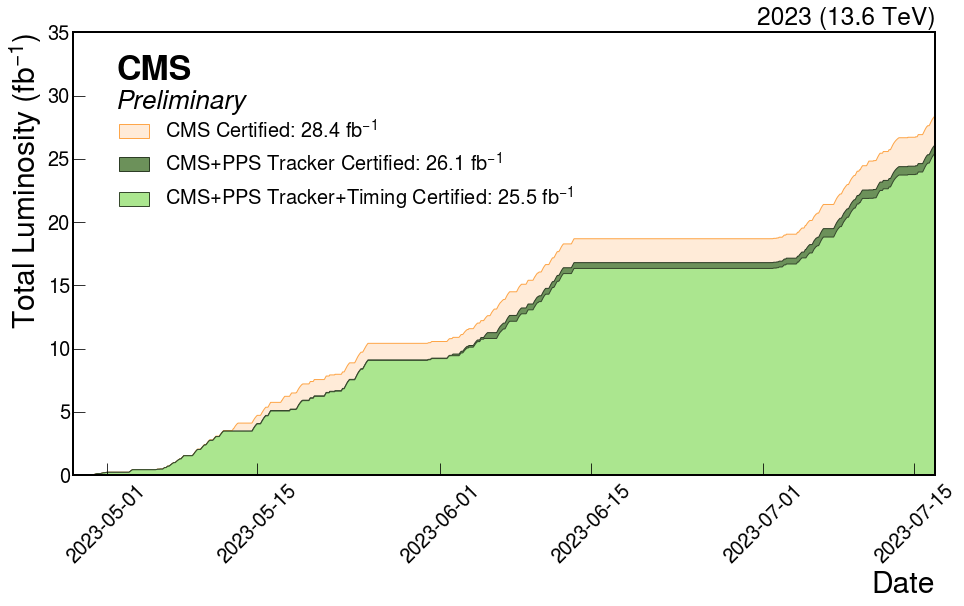

In [4]:
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use('CMS')

cms_tot_del = cms_2023_df['integrated_del_lumi'].iloc[-1]
cms_tot_rec = cms_2023_df['integrated_rec_lumi'].iloc[-1] 
pps_tot_track = cms_and_pps_2023_track_df['integrated_rec_lumi'].iloc[-1]
pps_tot_tracktime = cms_and_pps_2023_tracktime_df['integrated_rec_lumi'].iloc[-1]
min_date = min([cms_2023_df['date'].iloc[0],cms_and_pps_2023_track_df['date'].iloc[0],cms_and_pps_2023_tracktime_df['date'].iloc[0]])
max_date = max([cms_2023_df['date'].iloc[-1],cms_and_pps_2023_track_df['date'].iloc[-1],cms_and_pps_2023_tracktime_df['date'].iloc[-1]])

# Create the XY plot with a filled area under the line
plt.figure(figsize=(14, 9))
# plt.fill_between(cms_2023_df['date'], cms_2023_df['integrated_del_lumi'], color='#85d1fb', alpha=1, label=f'CMS Certified Delivered: {cms_tot_del:.1f}'+' fb$^{-1}$')
plt.fill_between(cms_2023_df['date'], cms_2023_df['integrated_rec_lumi'], color='#ffebd8', alpha=1, label=f'CMS Certified: {cms_tot_rec:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#fea649')
plt.fill_between(cms_and_pps_2023_track_df['date'], cms_and_pps_2023_track_df['integrated_rec_lumi'], color='#6c915a', alpha=1, label=f'CMS+PPS Tracker Certified: {pps_tot_track:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#2d3d26')
plt.fill_between(cms_and_pps_2023_tracktime_df['date'], cms_and_pps_2023_tracktime_df['integrated_rec_lumi'], color='#abe68f', alpha=1, label=f'CMS+PPS Tracker+Timing Certified: {pps_tot_tracktime:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#36492d')
plt.xlabel('Date',fontsize=30)
plt.ylabel('Total Luminosity (fb$^{-1}$)',fontsize=30)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((min_date,max_date))
plt.ylim((0,35))
plt.legend(loc='upper left', fontsize=20, bbox_to_anchor=(0.03,0.85))

# Remove minor ticks (which don't really make sense here)
plt.minorticks_off()

# Remove right and top axis. It's not CMS-style, I know, but they're really ugly and useless in this case
plt.tick_params(axis='both', which='both', direction='in', top=False, right=False)

# Add CMS Preliminary label
hep.cms.label('Preliminary',loc=2, data=True, rlabel='2023 (13.6 TeV)')

# Show the plot
plt.tight_layout()
plt.savefig('CMS_AND_PPS_lumi_2023.png',dpi=600)
plt.show()

## Plot without 'AND CMS'

We compute the first and last runs to consider for PPS.

In [5]:
min_run = min(pps_2023_track_df['run'].iloc[0],pps_2023_tracktime_df['run'].iloc[0])
max_run = max(pps_2023_track_df['run'].iloc[-1],pps_2023_tracktime_df['run'].iloc[-1])
print('Define the date variables in your terminal:')
print('min_run=\''+str(min_run)+'\'','max_run=\''+str(max_run)+'\'',sep='\n')

Define the date variables in your terminal:
min_run='366403'
max_run='370790'


Compute the non-JSON-filtered CMS lumi with
```
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/CMS_noFilter_2023.csv
brilcalc lumi -b "STABLE BEAMS" --normtag $normtag -u /fb --byls --output-style csv --begin $min_run --end $max_run -o $csv_output 
```

In [6]:
tot_cms_csv = 'CMS_noFilter_2023.csv'
cms_noFilter_2023_df = fillDataFrame(tot_cms_csv)

Parsing CMS_noFilter_2023.csv...


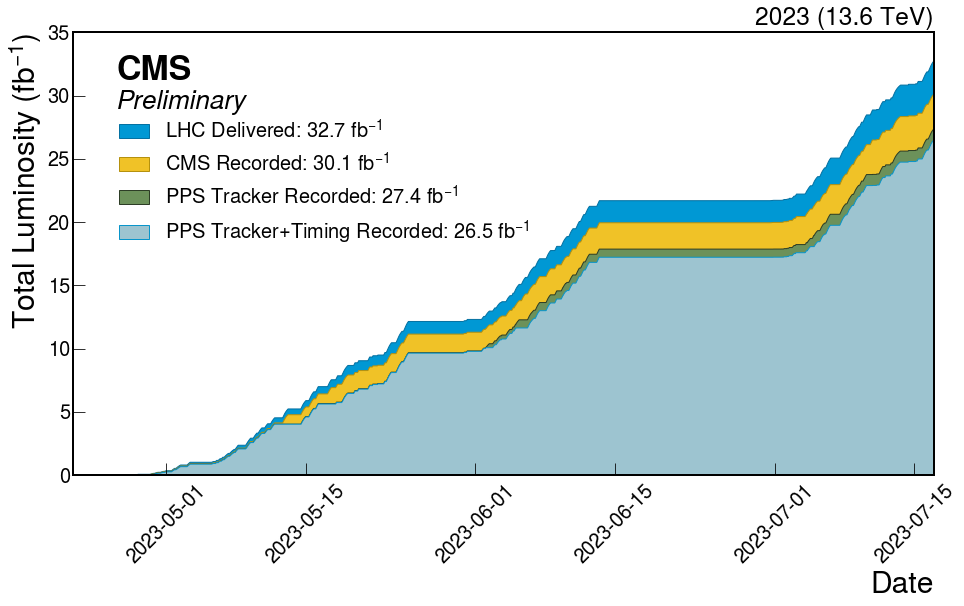

In [7]:
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use('CMS')

cms_tot_del = cms_noFilter_2023_df['integrated_del_lumi'].iloc[-1]
cms_tot_rec = cms_noFilter_2023_df['integrated_rec_lumi'].iloc[-1]
pps_tot_track = pps_2023_track_df['integrated_rec_lumi'].iloc[-1]
pps_tot_tracktime = pps_2023_tracktime_df['integrated_rec_lumi'].iloc[-1]
min_date = min([cms_noFilter_2023_df['date'].iloc[0],pps_2023_track_df['date'].iloc[0],pps_2023_tracktime_df['date'].iloc[0]])
max_date = max([cms_noFilter_2023_df['date'].iloc[-1],pps_2023_track_df['date'].iloc[-1],pps_2023_tracktime_df['date'].iloc[-1]])

# Create the XY plot with a filled area under the line
plt.figure(figsize=(14, 9))
plt.fill_between(cms_noFilter_2023_df['date'], cms_noFilter_2023_df['integrated_del_lumi'], color='#0098d4', alpha=1, label=f'LHC Delivered: {cms_tot_del:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#0471a2')
plt.fill_between(cms_noFilter_2023_df['date'], cms_noFilter_2023_df['integrated_rec_lumi'], color='#f0c227', alpha=1, label=f'CMS Recorded: {cms_tot_rec:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#b5910e')
plt.fill_between(pps_2023_track_df['date'], pps_2023_track_df['integrated_rec_lumi'], color='#6c915a', alpha=1, label=f'PPS Tracker Recorded: {pps_tot_track:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#2d3d26')
plt.fill_between(pps_2023_tracktime_df['date'], pps_2023_tracktime_df['integrated_rec_lumi'], color='#9dc4d0', alpha=1, label=f'PPS Tracker+Timing Recorded: {pps_tot_tracktime:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#0995ca')
plt.xlabel('Date',fontsize=30)
plt.ylabel('Total Luminosity (fb$^{-1}$)',fontsize=30)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((min_date,max_date))
plt.ylim((0,35))
plt.legend(loc='upper left', fontsize=20, bbox_to_anchor=(0.03,0.85))

# Remove minor ticks (which don't really make sense here)
plt.minorticks_off()

# Remove right and top axis. It's not CMS-style, I know, but they're really ugly and useless in this case
plt.tick_params(axis='both', which='both', direction='in', top=False, right=False)

# Add CMS Preliminary label
hep.cms.label('Preliminary',loc=2, data=True, rlabel='2023 (13.6 TeV)')

# Show the plot
plt.tight_layout()
plt.savefig('PPS_lumi_2023.png',dpi=600)
plt.show()

# 2024

## CMS AND PPS plot

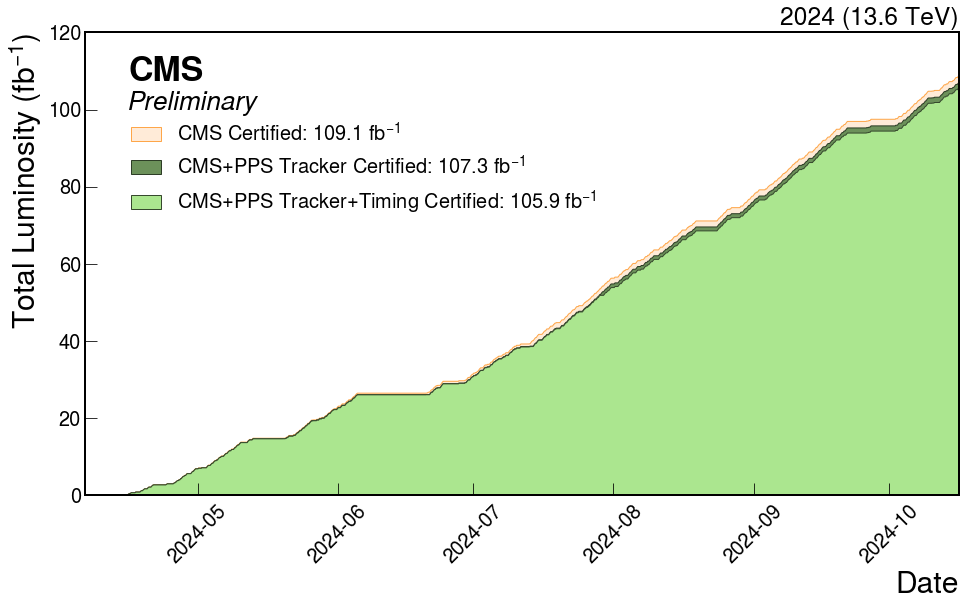

In [8]:
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use('CMS')
cms_and_pps_2024_tracktime_df = cms_and_pps_2024_tracktime_df.sort_values(by='date')

cms_tot_del = cms_2024_df['integrated_del_lumi'].iloc[-1]
cms_tot_rec = cms_2024_df['integrated_rec_lumi'].iloc[-1] 
pps_tot_track = cms_and_pps_2024_track_df['integrated_rec_lumi'].iloc[-1]
pps_tot_tracktime = cms_and_pps_2024_tracktime_df['integrated_rec_lumi'].iloc[-1]
min_date = min([cms_2024_df['date'].iloc[0],cms_and_pps_2024_track_df['date'].iloc[0],cms_and_pps_2024_tracktime_df['date'].iloc[0]])
max_date = max([cms_2024_df['date'].iloc[-1],cms_and_pps_2024_track_df['date'].iloc[-1],cms_and_pps_2024_tracktime_df['date'].iloc[-1]])

# Create the XY plot with a filled area under the line
plt.figure(figsize=(14, 9))
# plt.fill_between(cms_2024_df['date'], cms_2024_df['integrated_del_lumi'], color='#85d1fb', alpha=1, label=f'CMS Certified Delivered: {cms_tot_del:.1f}'+' fb$^{-1}$')
plt.fill_between(cms_2024_df['date'], cms_2024_df['integrated_rec_lumi'], color='#ffebd8', alpha=1, label=f'CMS Certified: {cms_tot_rec:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#fea649')
plt.fill_between(cms_and_pps_2024_track_df['date'], cms_and_pps_2024_track_df['integrated_rec_lumi'], color='#6c915a', alpha=1, label=f'CMS+PPS Tracker Certified: {pps_tot_track:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#2d3d26')
plt.fill_between(cms_and_pps_2024_tracktime_df['date'], cms_and_pps_2024_tracktime_df['integrated_rec_lumi'], color='#abe68f', alpha=1, label=f'CMS+PPS Tracker+Timing Certified: {pps_tot_tracktime:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#36492d')
plt.xlabel('Date',fontsize=30)
plt.ylabel('Total Luminosity (fb$^{-1}$)',fontsize=30)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((min_date,max_date))
plt.ylim((0,120))
plt.legend(loc='upper left', fontsize=20, bbox_to_anchor=(0.03,0.85))

# Remove minor ticks (which don't really make sense here)
plt.minorticks_off()

# Remove right and top axis. It's not CMS-style, I know, but they're really ugly and useless in this case
plt.tick_params(axis='both', which='both', direction='in', top=False, right=False)

# Add CMS Preliminary label
hep.cms.label('Preliminary',loc=2, data=True, rlabel='2024 (13.6 TeV)')

# Show the plot
plt.tight_layout()
plt.savefig('CMS_AND_PPS_lumi_2024.png',dpi=600)
plt.show()

## Plot without 'AND CMS'

We compute the first and last runs to consider for PPS.

In [9]:
min_run = min(pps_2024_track_df['run'].iloc[0],pps_2024_tracktime_df['run'].iloc[0])
max_run = max(pps_2024_track_df['run'].iloc[-1],pps_2024_tracktime_df['run'].iloc[-1])
print('Define the date variables in your terminal:')
print('min_run=\''+str(min_run)+'\'','max_run=\''+str(max_run)+'\'',sep='\n')

Define the date variables in your terminal:
min_run='378981'
max_run='386951'


Compute the non-JSON-filtered CMS lumi with
```
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/CMS_noFilter_2024.csv
brilcalc lumi -b "STABLE BEAMS" --normtag $normtag -u /fb --byls --output-style csv --begin $min_run --end $max_run -o $csv_output 
```

Had to drop the `-c web` option, because I'm getting a Python error from brilcalc...

In [10]:
tot_cms_csv = 'CMS_noFilter_2024.csv'
cms_noFilter_2024_df = fillDataFrame(tot_cms_csv)

Parsing CMS_noFilter_2024.csv...


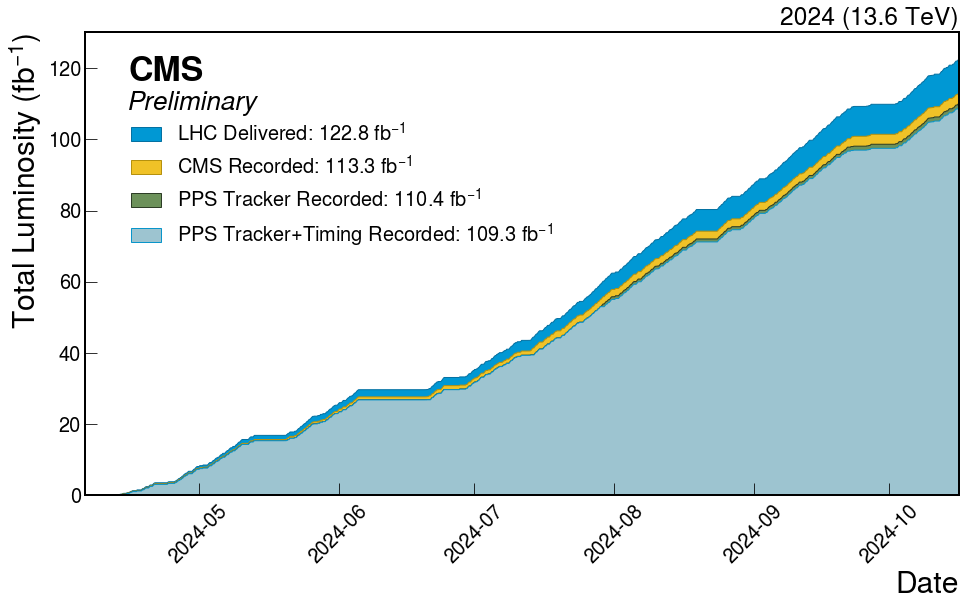

In [11]:
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use('CMS')

cms_tot_del = cms_noFilter_2024_df['integrated_del_lumi'].iloc[-1]
cms_tot_rec = cms_noFilter_2024_df['integrated_rec_lumi'].iloc[-1]
pps_tot_track = pps_2024_track_df['integrated_rec_lumi'].iloc[-1]
pps_tot_tracktime = pps_2024_tracktime_df['integrated_rec_lumi'].iloc[-1]
min_date = min([cms_noFilter_2024_df['date'].iloc[0],pps_2024_track_df['date'].iloc[0],pps_2024_tracktime_df['date'].iloc[0]])
max_date = max([cms_noFilter_2024_df['date'].iloc[-1],pps_2024_track_df['date'].iloc[-1],pps_2024_tracktime_df['date'].iloc[-1]])

# Create the XY plot with a filled area under the line
plt.figure(figsize=(14, 9))
plt.fill_between(cms_noFilter_2024_df['date'], cms_noFilter_2024_df['integrated_del_lumi'], color='#0098d4', alpha=1, label=f'LHC Delivered: {cms_tot_del:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#0471a2')
plt.fill_between(cms_noFilter_2024_df['date'], cms_noFilter_2024_df['integrated_rec_lumi'], color='#f0c227', alpha=1, label=f'CMS Recorded: {cms_tot_rec:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#b5910e')
plt.fill_between(pps_2024_track_df['date'], pps_2024_track_df['integrated_rec_lumi'], color='#6c915a', alpha=1, label=f'PPS Tracker Recorded: {pps_tot_track:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#2d3d26')
plt.fill_between(pps_2024_tracktime_df['date'], pps_2024_tracktime_df['integrated_rec_lumi'], color='#9dc4d0', alpha=1, label=f'PPS Tracker+Timing Recorded: {pps_tot_tracktime:.1f}'+' fb$^{-1}$',linewidth=1,edgecolor='#0995ca')
plt.xlabel('Date',fontsize=30)
plt.ylabel('Total Luminosity (fb$^{-1}$)',fontsize=30)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((min_date,max_date))
plt.ylim((0,130))
plt.legend(loc='upper left', fontsize=20, bbox_to_anchor=(0.03,0.85))

# Remove minor ticks (which don't really make sense here)
plt.minorticks_off()

# Remove right and top axis. It's not CMS-style, I know, but they're really ugly and useless in this case
plt.tick_params(axis='both', which='both', direction='in', top=False, right=False)

# Add CMS Preliminary label
hep.cms.label('Preliminary',loc=2, data=True, rlabel='2024 (13.6 TeV)')

# Show the plot
plt.tight_layout()
plt.savefig('PPS_lumi_2024.png',dpi=600)
plt.show()